# BTC price & movement prediction, Glassnode 2024

## ToC

- preprocessing: 
  - selecting only float metrics
  - dropping all price columns except one for target
  - check for multicolliniarity & drop values with corr >= 0.95
  - reduce number of features:
    - Reducing shape:
      - `PCA`
      - `t-SNE`, `UMAP`
    <!-- - Option 2: with filter methods:
      - `SelectKBest` + `f_classif`
      - `mutual_info_classif`
      - `Lasso` + `SelectFromModel`
      - `RFE` -->
  - optuna
  - select more important features: ....
- classification:
  - LightGBM classi
  - SVM classification
- sklearn regression
  - RandomForest Regressor
- RNN, LSTM, ANN
- Convolutional Neural Networks (CNNs)
- Transformer models
- 

## TODO:

- create lag features
- create rolling stats features
- create ema and sma features
- t-SNE
- include PCA as a hyperparameter
- how to find the most important features?
- use catboost and xgboost
- optuna pruning to speed up




- Boruta feature selection and the CNN–LSTM model consistently outperformed other configurations

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
folder_path = 'glassnode_data_btc'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

## Filtering

In [3]:
dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
combined_df = pd.concat(dataframes, ignore_index=True)

In [4]:
combined_df.head()

,timestamp,v,o,balance,changes,open_interest,ath_price,current_price,total_supply,partitions,volumes,total_volume,balances,daily_volume
0,2021-02-16,114.024889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-17,107.220092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-18,100.845519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-19,101.234905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-20,98.642269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
len(dataframes)

669

In [6]:
dataframes = []

for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    suffix = file[4:].replace('.csv', '')
    df.rename(columns={col: f"{col}_{suffix}" for col in df.columns if col != 'timestamp'}, inplace=True)
    df.set_index('timestamp', inplace=True)
    dataframes.append(df)

combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.join(df, how='outer')


In [7]:
combined_df = combined_df.loc['2020-01-01':'2024-06-01']

In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1614 entries, 2020-01-01 to 2024-06-01
Columns: 691 entries, v_v1_metrics_derivatives_options_atm_implied_volatility_1_week to v_v1_metrics_entities_active_count
dtypes: float64(566), object(125)
memory usage: 8.5+ MB


In [9]:
df = combined_df.copy(deep=True)

In [10]:
df.head()

,v_v1_metrics_derivatives_options_atm_implied_volatility_1_week,v_v1_metrics_transactions_transfers_volume_exchanges_net_pit,v_v1_metrics_indicators_sopr,v_v1_metrics_indicators_realized_loss_to_exchanges_account_based_pit,v_v1_metrics_distribution_balance_otc_desks_pit,o_v1_metrics_breakdowns_sopr_by_wallet_size,o_v1_metrics_breakdowns_marketcap_usd_by_age,v_v1_metrics_mining_miners_outflow_multiple,v_v1_metrics_institutions_purpose_etf_holdings_sum,v_v1_metrics_indicators_svl_3y_5y,...,v_v1_metrics_supply_active_5y_7y,v_v1_metrics_indicators_realized_loss_sth_to_exchanges_account_based_pit,v_v1_metrics_transactions_transfers_from_miners_count,v_v1_metrics_distribution_balance_exchanges_relative_pit,v_v1_metrics_supply_active_24h,v_v1_metrics_transactions_transfers_volume_to_miners_sum,o_v1_metrics_breakdowns_spent_volume_sum_by_age,v_v1_metrics_transactions_runes_count_sum,v_v1_metrics_transactions_transfers_exchanges_to_whales_count_pit,v_v1_metrics_entities_active_count
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,1037.507591,0.997800,NaN,NaN,"{'0001_001': 0.9895968046017839, '001_01': 0.9...","{'1d_1w': 2317861858.853726, '1m_3m': 10808927...",0.833294,NaN,10.722187,...,1.238982e+06,NaN,5432.0,0.106039,79650.894873,2361.162100,"{'1d_1w': 26231.39682919, '1m_3m': 3411.108262...",NaN,NaN,155324.0
2020-01-02,NaN,-1261.073521,0.996801,NaN,NaN,"{'0001_001': 0.9846696537723294, '001_01': 0.9...","{'1d_1w': 1898039839.9722486, '1m_3m': 1052758...",0.961739,NaN,17.939656,...,1.238562e+06,NaN,5496.0,0.106009,155086.694678,2112.729399,"{'1d_1w': 55769.086002749995, '1m_3m': 5696.00...",NaN,NaN,205786.0
2020-01-03,NaN,2230.358147,1.001081,NaN,NaN,"{'0001_001': 0.998744520604327, '001_01': 0.99...","{'1d_1w': 2027456903.4646225, '1m_3m': 1124771...",1.002015,NaN,55.335264,...,1.230096e+06,NaN,5683.0,0.106217,229234.713800,2432.984874,"{'1d_1w': 56103.70366364001, '1m_3m': 6717.655...",NaN,NaN,213361.0
2020-01-04,NaN,1092.685966,0.996234,NaN,NaN,"{'0001_001': 0.9969779371830698, '001_01': 0.9...","{'1d_1w': 2731276270.2818646, '1m_3m': 1129355...",0.998218,NaN,591.834312,...,1.229811e+06,NaN,4802.0,0.106276,114102.789783,2373.306192,"{'1d_1w': 25482.16708766, '1m_3m': 14252.30297...",NaN,NaN,188436.0
2020-01-05,NaN,-165.661735,1.001827,NaN,NaN,"{'0001_001': 1.00438172946638, '001_01': 1.005...","{'1d_1w': 2922423174.6289754, '1m_3m': 1123046...",0.958034,NaN,312.393456,...,1.229047e+06,NaN,4791.0,0.106314,92918.415125,2427.533838,"{'1d_1w': 29576.064364120008, '1m_3m': 3980.70...",NaN,NaN,192421.0


In [11]:
float_data = df.rename(columns={'v_v1_metrics_market_price_usd_close': 'price'}).select_dtypes(include=['float', 'float64', 'float32'])

## Multicollinearity check

In [12]:
corr_matrix = float_data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = []
correlated_features = set()

for column in upper_tri.columns:
    if column not in correlated_features and column != 'price':
        high_corr = upper_tri.index[upper_tri[column] >= 0.95].tolist()
        if high_corr:
            to_drop.append(column)
            correlated_features.update(high_corr)

float_data = float_data.drop(columns=to_drop)
print(f"Columns to drop: {to_drop}")

Columns to drop: ['v_v1_metrics_indicators_nupl_more_155_account_based_pit', 'v_v1_metrics_distribution_balance_blackrock', 'v_v1_metrics_entities_supply_balance_less_0001', 'v_v1_metrics_entities_supply_balance_10_100_pit', 'v_v1_metrics_entities_supply_balance_001_01_pit', 'v_v1_metrics_transactions_transfers_volume_entity_adjusted_median', 'total_supply_v1_metrics_indicators_utxo_realized_price_distribution_ath', 'v_v1_metrics_entities_supply_balance_1k_10k_pit', 'v_v1_metrics_supply_inflation_rate', 'v_v1_metrics_market_spot_volume_daily_sum', 'v_v1_metrics_supply_sth_sum', 'v_v1_metrics_indicators_unrealized_loss_account_based', 'ath_price_v1_metrics_indicators_urpd_entity_adjusted_pit', 'current_price_v1_metrics_indicators_urpd_entity_adjusted_pit', 'total_supply_v1_metrics_indicators_urpd_entity_adjusted_pit', 'v_v1_metrics_distribution_balance_wbtc_pit', 'v_v1_metrics_addresses_supply_balance_001_01', 'v_v1_metrics_transactions_transfers_volume_from_coinjoins_sum_pit', 'v_v1_me

In [13]:
len(to_drop)

243

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

## Drop NaN cols, Create `price_up` boolean feature

In [15]:
if 'price_up' not in float_data.columns:
    if 'price' in float_data.columns:
        # create 'price_up': 1 if price goes up the next day, 0 otherwise
        float_data['price_up'] = (float_data['price'].shift(-1) > float_data['price']).astype(int)
        float_data = float_data.dropna(subset=['price_up'])
    else:
        raise ValueError("DataFrame should contain 'price'")

print("distribution of classes 'price_up':")
print(float_data['price_up'].value_counts())

X = float_data.drop(columns=['price', 'price_up'])
y = float_data['price_up'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"shape X_train: {X_train.shape}")
print(f"shape X_test: {X_test.shape}")

###### WHY????

cols_all_nan = X_train.columns[X_train.isnull().all()].tolist()
print(f"cols with NaN X_train: {cols_all_nan}")

if cols_all_nan:
    X_train = X_train.drop(columns=cols_all_nan)
    X_test = X_test.drop(columns=cols_all_nan)
    print(f"after dropping NaN cols X_train: {X_train.shape}")
    print(f"after dropping NaN cols X_test: {X_test.shape}")
else:
    print("no cols with NaN X_train.")

distribution of classes 'price_up':
price_up
1    823
0    791
Name: count, dtype: int64
shape X_train: (1291, 322)
shape X_test: (323, 322)
cols with NaN X_train: ['changes_v1_metrics_derivatives_futures_open_interest_latest', 'open_interest_v1_metrics_derivatives_futures_open_interest_latest', 'v_v1_metrics_distribution_balance_german_government_pit', 'v_v1_metrics_transactions_runes_fee_share', 'v_v1_metrics_institutions_us_spot_etf_flows_net', 'changes_v1_metrics_derivatives_futures_volume_daily_latest', 'daily_volume_v1_metrics_derivatives_futures_volume_daily_latest', 'v_v1_metrics_distribution_balance_us_government_pit']
after dropping NaN cols X_train: (1291, 314)
after dropping NaN cols X_test: (323, 314)


## Fill Missing Values, Scaling

In [16]:
X_train.shape

(1291, 314)

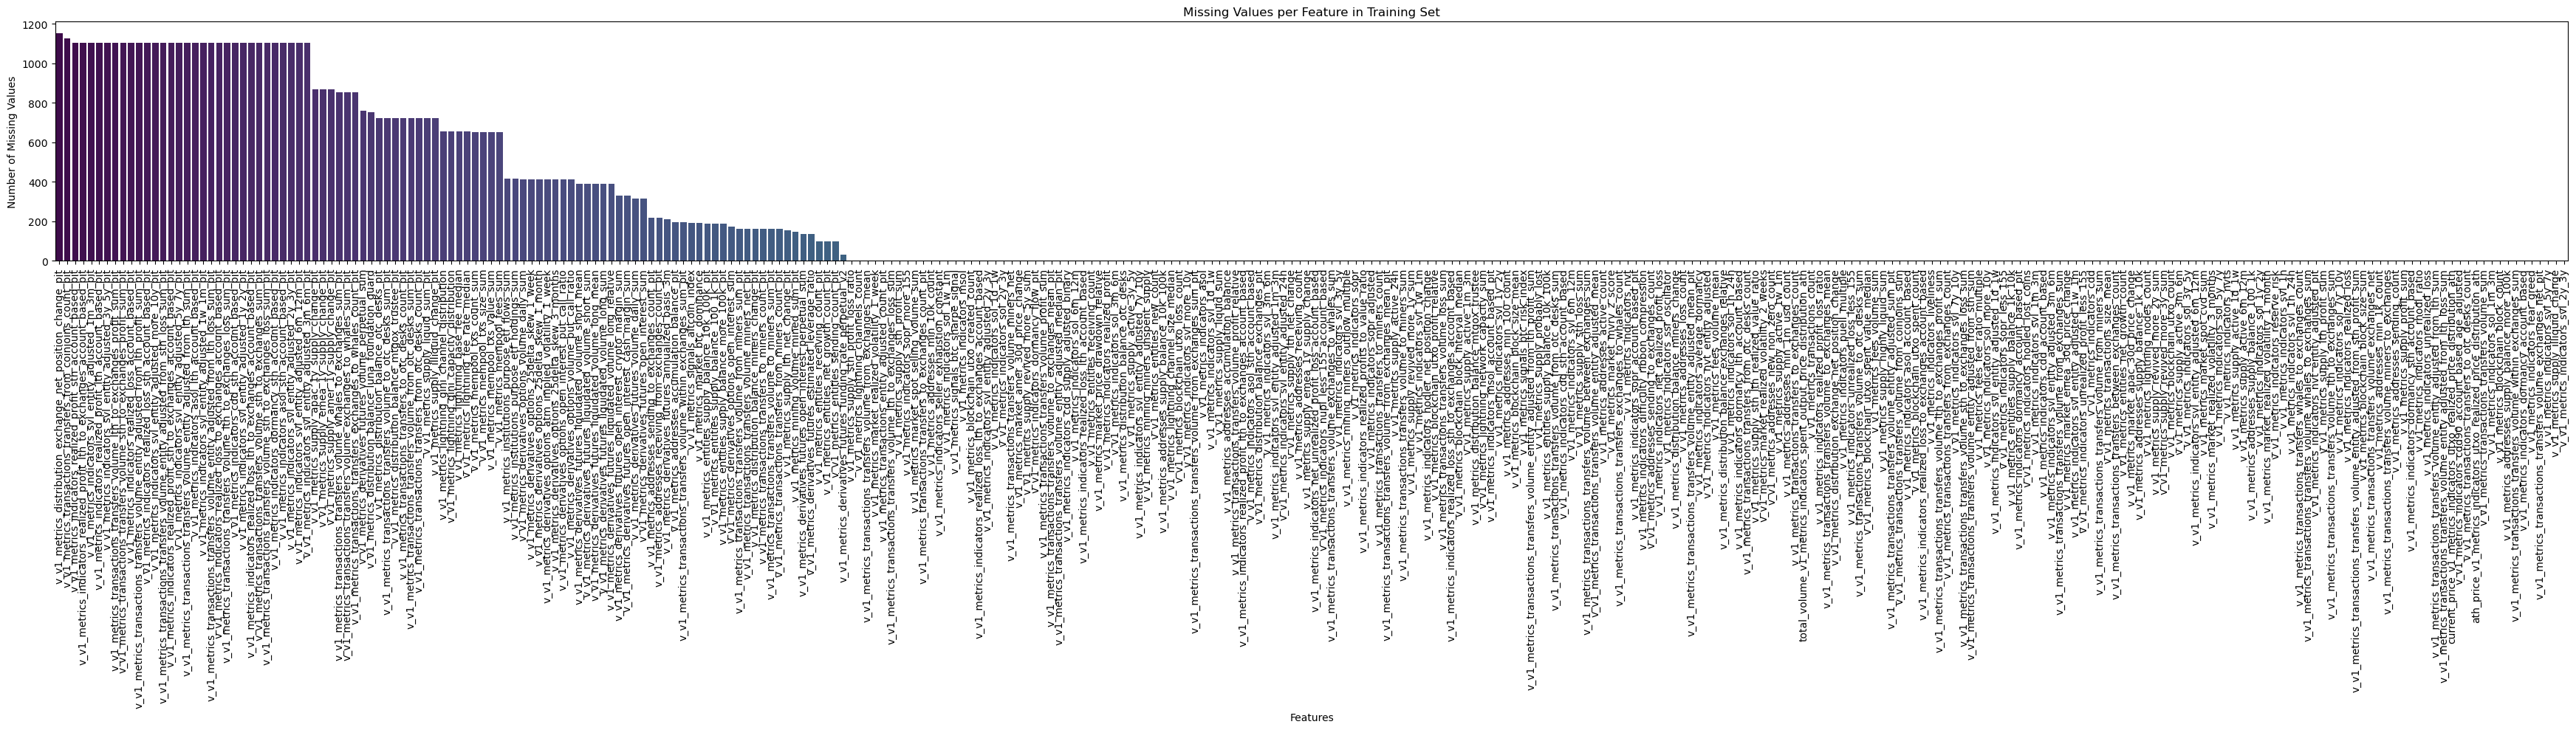

In [17]:
def show_NaNs():
    missing_counts = X_train.isnull().sum().sort_values(ascending=False)
    plt.figure(figsize=(35, 10))
    sns.barplot(x=missing_counts.index, y=missing_counts.values, hue=missing_counts.index, palette="viridis", legend=False)
    plt.xticks(rotation=90)
    plt.title('Missing Values per Feature in Training Set')
    plt.xlabel('Features')
    plt.ylabel('Number of Missing Values')
    plt.tight_layout()
    plt.show()
    
show_NaNs()

In [18]:
missing_threshold = 200
missing_counts = X_train.isnull().sum()
columns_to_drop = missing_counts[missing_counts > missing_threshold].index
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)
print(f'dropped {len(columns_to_drop)} cols')

dropped 77 cols


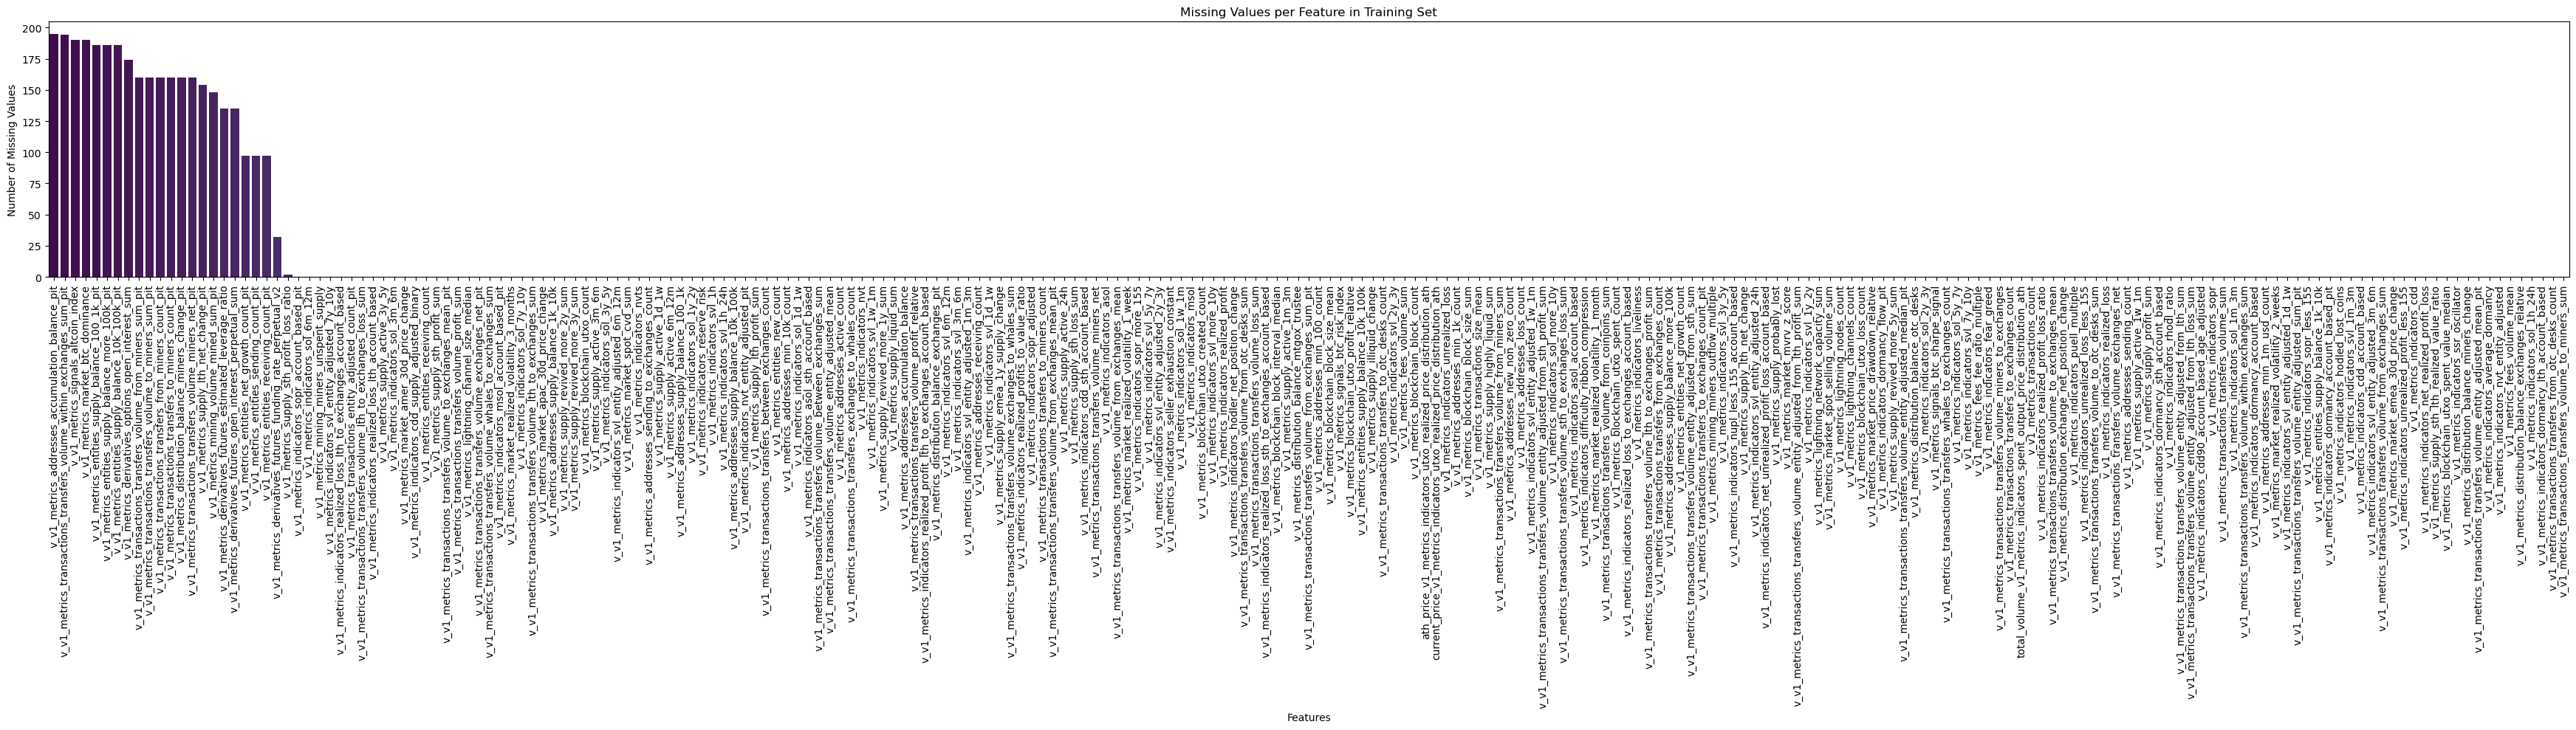

In [19]:
show_NaNs()

In [26]:
# Imputation
# KNNIMUTER AS AN OPTION
imputer = IterativeImputer(random_state=42, max_iter=2, sample_posterior=True)
imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

print("Missing values after imputer", X_train_imputed.isnull().sum().sum(), X_test_imputed.isnull().sum().sum())

# Scaling
scaler = StandardScaler()
scaler.fit(X_train_imputed)  

X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns, index=X_train_imputed.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns, index=X_test_imputed.index)


Missing values after imputer 0 0


## PCA

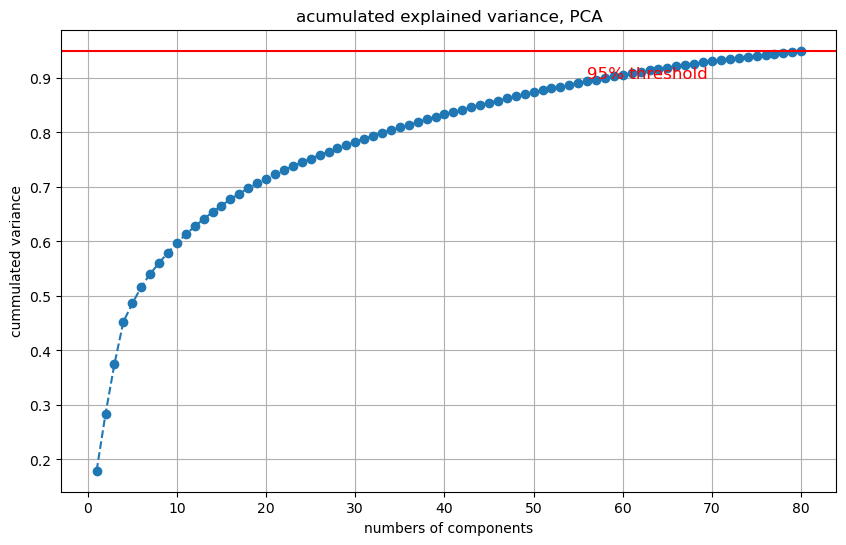

In [ ]:
n_components = 80 # is inputted manually, but might be optimized to find 95% variance

pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
X_test_pca = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('acumulated explained variance, PCA')
plt.xlabel('numbers of components')
plt.ylabel('cummulated variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(n_components * 0.7, 0.90, '95% threshold', color='red', fontsize=12)
plt.show()

## LightGBM classifier as a baseline

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score, f1_score
import shap

In [43]:
def select_features_pca(X, n_features_list):
    pca = PCA()
    pca.fit(X)
    components = pd.DataFrame(pca.components_, columns=X.columns)
    explained_variance = pca.explained_variance_ratio_
    
    feature_importance = np.abs(components.T @ explained_variance)
    feature_importance = pd.Series(feature_importance, index=X.columns)
    feature_importance.sort_values(ascending=False, inplace=True)
    
    selected_features = {}
    for n_features in n_features_list:
        top_features = feature_importance.iloc[:n_features].index.tolist()
        selected_features[n_features] = top_features
    return selected_features

def select_features_lightgbm(X, y, n_features_list):
    model = LGBMClassifier(random_state=42)
    model.fit(X, y)
    importance = model.feature_importances_
    feature_importance = pd.Series(importance, index=X.columns)
    feature_importance.sort_values(ascending=False, inplace=True)
    
    selected_features = {}
    for n_features in n_features_list:
        top_features = feature_importance.iloc[:n_features].index.tolist()
        selected_features[n_features] = top_features
    return selected_features

def select_features_correlation(X, y, n_features_list):
    target_correlation = X.apply(lambda x: x.corr(y))
    target_correlation = target_correlation.abs()
    target_correlation.sort_values(ascending=False, inplace=True)
    
    selected_features = {}
    for n_features in n_features_list:
        top_features = target_correlation.iloc[:n_features].index.tolist()
        selected_features[n_features] = top_features
    return selected_features

def select_features_shap(X, y, n_features_list):
    model = LGBMClassifier(random_state=42)
    model.fit(X, y)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    shap_values_mean = np.abs(shap_values[1]).mean(axis=0)
    feature_importance = pd.Series(shap_values_mean, index=X.columns)
    feature_importance.sort_values(ascending=False, inplace=True)
    
    selected_features = {}
    for n_features in n_features_list:
        top_features = feature_importance.iloc[:n_features].index.tolist()
        selected_features[n_features] = top_features
    return selected_features

# Feature Selection
n_features_list = [10]
selected_features_pca = select_features_pca(X_train_scaled, n_features_list)
selected_features_lightgbm = select_features_lightgbm(X_train_imputed, y_train, n_features_list)
selected_features_correlation = select_features_correlation(X_train_imputed, y_train, n_features_list)
selected_features_shap = select_features_shap(X_train_imputed, y_train, n_features_list)

[LightGBM] [Info] Number of positive: 655, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58308
[LightGBM] [Info] Number of data points in the train set: 1291, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507359 -> initscore=0.029437
[LightGBM] [Info] Start training from score 0.029437
[LightGBM] [Info] Number of positive: 655, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58308
[LightGBM] [Info] Number of data points in the train set: 1291, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507359 -> initscore=0.029437
[LightGBM] [Info] Start training from score 0.029437


/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [60]:
super_features_set = set(*selected_features_pca.values()).union(set(*selected_features_lightgbm.values()).union(set(*selected_features_correlation.values()).union(set(*selected_features_shap.values()))))
print(len(super_features_set))

39


In [45]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'verbosity': -1
    }
    model = LGBMClassifier(random_state=42, **param)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train_pca, y_train, cv=tscv, scoring='f1', n_jobs=-1)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300, timeout=1800)
print("Best params:", study.best_params)

best_params = study.best_params
best_model = LGBMClassifier(
    random_state=42,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    scale_pos_weight=best_params['scale_pos_weight']
)

best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Report:")
print(classification_report(y_test, y_pred))

[I 2024-11-18 11:45:26,604] A new study created in memory with name: no-name-c2216fff-1ef0-4530-9f3d-cc4f9971fc06
[I 2024-11-18 11:45:30,590] Trial 0 finished with value: 0.5647697450178197 and parameters: {'n_estimators': 200, 'learning_rate': 0.011977377966364224, 'max_depth': 43, 'num_leaves': 151, 'min_child_samples': 46, 'subsample': 0.6160991895957112, 'colsample_bytree': 0.518201588194605, 'reg_alpha': 0.026692107923776524, 'reg_lambda': 1.0830371080942896e-06, 'scale_pos_weight': 1.0178017376257058}. Best is trial 0 with value: 0.5647697450178197.
[I 2024-11-18 11:45:34,470] Trial 1 finished with value: 0.5871648609282567 and parameters: {'n_estimators': 500, 'learning_rate': 0.13934011306344096, 'max_depth': 36, 'num_leaves': 133, 'min_child_samples': 25, 'subsample': 0.6565615776469194, 'colsample_bytree': 0.931805373166939, 'reg_alpha': 0.001293754751849978, 'reg_lambda': 5.556223048144286, 'scale_pos_weight': 1.73320884583454}. Best is trial 1 with value: 0.5871648609282567

Best params: {'n_estimators': 100, 'learning_rate': 0.015200631223248285, 'max_depth': 24, 'num_leaves': 232, 'min_child_samples': 97, 'subsample': 0.6994509932268455, 'colsample_bytree': 0.8074872823789147, 'reg_alpha': 0.008598536367495217, 'reg_lambda': 6.331821998326496e-08, 'scale_pos_weight': 1.9502199703011684}
[LightGBM] [Info] Number of positive: 655, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 1291, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507359 -> initscore=0.029437
[LightGBM] [Info] Start training from score 0.029437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [63]:
# from optuna.visualization import plot_optimization_history, plot_param_importances

# fig1 = plot_optimization_history(study)
# fig1.show()

# fig2 = plot_param_importances(study)
# fig2.show()

In [46]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'verbosity': 0,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(random_state=42, **param)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train_pca, y_train, cv=tscv, scoring='f1', n_jobs=-1)
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=300, timeout=1800)
print("Best params XGB:", study_xgb.best_params)

best_params_xgb = study_xgb.best_params
best_model_xgb = XGBClassifier(
    random_state=42,
    n_estimators=best_params_xgb['n_estimators'],
    learning_rate=best_params_xgb['learning_rate'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    gamma=best_params_xgb['gamma'],
    reg_alpha=best_params_xgb['reg_alpha'],
    reg_lambda=best_params_xgb['reg_lambda'],
    scale_pos_weight=best_params_xgb['scale_pos_weight'],
    verbosity=0,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_model_xgb.fit(X_train_pca, y_train)
y_pred_xgb = best_model_xgb.predict(X_test_pca)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"Accuracy XGB: {accuracy_xgb:.2f}")
print(f"F1-Score XGB: {f1_xgb:.2f}")
print("Report XGB:")
print(classification_report(y_test, y_pred_xgb))

[I 2024-11-18 12:03:50,947] A new study created in memory with name: no-name-49a77bff-1086-4987-871e-0301efd781ed
[I 2024-11-18 12:03:54,054] Trial 0 finished with value: 0.6437130793469562 and parameters: {'n_estimators': 200, 'learning_rate': 0.08355554460188659, 'max_depth': 46, 'min_child_weight': 2, 'subsample': 0.6740736314492785, 'colsample_bytree': 0.8884126819673142, 'gamma': 4.236321628795833, 'reg_alpha': 4.573756627470576, 'reg_lambda': 9.19016115074447e-05, 'scale_pos_weight': 1.734762991664073}. Best is trial 0 with value: 0.6437130793469562.
[I 2024-11-18 12:03:54,765] Trial 1 finished with value: 0.599353640434909 and parameters: {'n_estimators': 100, 'learning_rate': 0.04586884547528731, 'max_depth': 14, 'min_child_weight': 10, 'subsample': 0.6150619020317629, 'colsample_bytree': 0.6079739311057152, 'gamma': 1.0501511779060901, 'reg_alpha': 4.04246060504843e-07, 'reg_lambda': 0.00013622983156813252, 'scale_pos_weight': 1.178511145495378}. Best is trial 0 with value: 0.

Best params XGB: {'n_estimators': 100, 'learning_rate': 0.018069070084664667, 'max_depth': 27, 'min_child_weight': 10, 'subsample': 0.6985794321694923, 'colsample_bytree': 0.7377606777780092, 'gamma': 1.805057193295337, 'reg_alpha': 7.1647973102075095, 'reg_lambda': 3.295899987786379, 'scale_pos_weight': 1.2159541243493168}
Accuracy XGB: 0.51
F1-Score XGB: 0.67
Report XGB:
              precision    recall  f1-score   support

           0       0.36      0.03      0.06       155
           1       0.51      0.95      0.67       168

    accuracy                           0.51       323
   macro avg       0.44      0.49      0.36       323
weighted avg       0.44      0.51      0.38       323



## Regression

In [62]:
float_data['price'] 

timestamp
2020-01-01     7199.661101
2020-01-02     6985.659023
2020-01-03     7347.597378
2020-01-04     7415.202445
2020-01-05     7410.812541
                  ...     
2024-05-28    68280.594264
2024-05-29    67573.789721
2024-05-30    68378.323206
2024-05-31    67488.324170
2024-06-01    67705.148716
Name: price, Length: 1614, dtype: float64

shape X_train: (1291, 322)
shape X_test: (323, 322)
cols with NaN X_train: ['changes_v1_metrics_derivatives_futures_open_interest_latest', 'open_interest_v1_metrics_derivatives_futures_open_interest_latest', 'v_v1_metrics_distribution_balance_german_government_pit', 'v_v1_metrics_transactions_runes_fee_share', 'v_v1_metrics_institutions_us_spot_etf_flows_net', 'changes_v1_metrics_derivatives_futures_volume_daily_latest', 'daily_volume_v1_metrics_derivatives_futures_volume_daily_latest', 'v_v1_metrics_distribution_balance_us_government_pit']
after dropping NaN cols X_train: (1291, 314)
after dropping NaN cols X_test: (323, 314)
Missing values after imputer 0 0


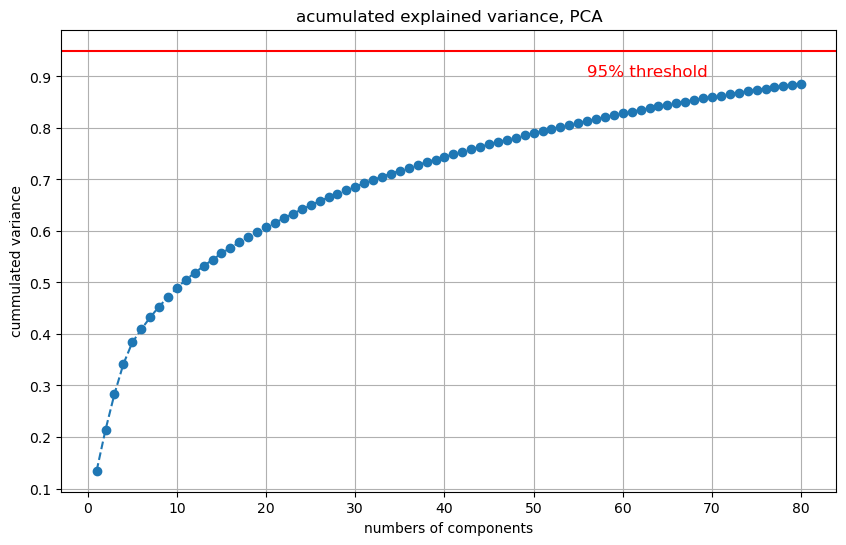

In [64]:
y = float_data['price'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"shape X_train: {X_train.shape}")
print(f"shape X_test: {X_test.shape}")


cols_all_nan = X_train.columns[X_train.isnull().all()].tolist()
print(f"cols with NaN X_train: {cols_all_nan}")

if cols_all_nan:
    X_train = X_train.drop(columns=cols_all_nan)
    X_test = X_test.drop(columns=cols_all_nan)
    print(f"after dropping NaN cols X_train: {X_train.shape}")
    print(f"after dropping NaN cols X_test: {X_test.shape}")
else:
    print("no cols with NaN X_train.")
    
    
imputer = IterativeImputer(random_state=42, max_iter=2, sample_posterior=True)
imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

print("Missing values after imputer", X_train_imputed.isnull().sum().sum(), X_test_imputed.isnull().sum().sum())

scaler = StandardScaler()
scaler.fit(X_train_imputed)  

X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns, index=X_train_imputed.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns, index=X_test_imputed.index)

n_components = 80 # is inputted manually, but might be optimized to find 95% variance

pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
X_test_pca = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('acumulated explained variance, PCA')
plt.xlabel('numbers of components')
plt.ylabel('cummulated variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(n_components * 0.7, 0.90, '95% threshold', color='red', fontsize=12)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import optuna
import numpy as np

def objective_rf_reg(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    }
    
    model = RandomForestRegressor(random_state=42, **param)
    tscv = TimeSeriesSplit(n_splits=5)
    
    scores = cross_val_score(model, X_train_pca, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    return np.mean(scores)

study_rf_reg = optuna.create_study(direction='maximize')
study_rf_reg.optimize(objective_rf_reg, n_trials=200, timeout=1800)

print("best params RandomForestRegressor:", study_rf_reg.best_params)

best_params_rf_reg = study_rf_reg.best_params
best_model_rf_reg = RandomForestRegressor(random_state=42, **best_params_rf_reg)
best_model_rf_reg.fit(X_train_pca, y_train)

y_pred_rf_reg = best_model_rf_reg.predict(X_test_pca)

rmse = root_mean_squared_error(y_test, y_pred_rf_reg, squared=False)
mae = mean_absolute_error(y_test, y_pred_rf_reg)
r2 = r2_score(y_test, y_pred_rf_reg)

print(f"RMSE RandomForestRegressor: {rmse:.2f}")
print(f"MAE RandomForestRegressor: {mae:.2f}")
print(f"R² RandomForestRegressor: {r2:.2f}")

[I 2024-11-18 16:06:48,057] A new study created in memory with name: no-name-efb7f33e-37c0-4285-8324-3c1bb32c3b4f
[I 2024-11-18 16:06:53,215] Trial 0 finished with value: -15100.101000813764 and parameters: {'n_estimators': 832, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'bootstrap': False, 'min_weight_fraction_leaf': 0.2871730691688883}. Best is trial 0 with value: -15100.101000813764.
[I 2024-11-18 16:06:54,804] Trial 1 finished with value: -15313.12003386851 and parameters: {'n_estimators': 803, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'min_weight_fraction_leaf': 0.3731206752451522}. Best is trial 0 with value: -15100.101000813764.
[W 2024-11-18 16:06:54,858] Trial 2 failed with parameters: {'n_estimators': 732, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 'auto', 'bootstrap': False, 'min_weight_fraction_leaf': 0.011343739757988303} b

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.


In [66]:
y_train.head()

timestamp
2020-01-01    7199.661101
2020-01-02    6985.659023
2020-01-03    7347.597378
2020-01-04    7415.202445
2020-01-05    7410.812541
Name: price, dtype: float64

In [ ]:


# def objective_cat(trial):
#     param = {
#         'iterations': trial.suggest_categorical('iterations', [100, 200, 300, 400, 500]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'depth': trial.suggest_int('depth', 5, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
#         'verbose': False
#     }
#     model = CatBoostClassifier(random_state=42, **param)
#     tscv = TimeSeriesSplit(n_splits=5)
#     scores = cross_val_score(model, X_train_pca, y_train, cv=tscv, scoring='f1', n_jobs=-1)
#     return np.mean(scores)

# study_cat = optuna.create_study(direction='maximize')
# study_cat.optimize(objective_cat, n_trials=200, timeout=1800)
# print("Best params CatBoost:", study_cat.best_params)

# best_params_cat = study_cat.best_params
# best_model_cat = CatBoostClassifier(
#     random_state=42,
#     iterations=best_params_cat['iterations'],
#     learning_rate=best_params_cat['learning_rate'],
#     depth=best_params_cat['depth'],
#     l2_leaf_reg=best_params_cat['l2_leaf_reg'],
#     bagging_temperature=best_params_cat['bagging_temperature'],
#     border_count=best_params_cat['border_count'],
#     scale_pos_weight=best_params_cat['scale_pos_weight'],
#     verbose=False
# )

# best_model_cat.fit(X_train_pca, y_train)
# y_pred_cat = best_model_cat.predict(X_test_pca)

# accuracy_cat = accuracy_score(y_test, y_pred_cat)
# f1_cat = f1_score(y_test, y_pred_cat)
# print(f"Accuracy CatBoost: {accuracy_cat:.2f}")
# print(f"F1-Score CatBoost: {f1_cat:.2f}")
# print("Report CatBoost:")
# print(classification_report(y_test, y_pred_cat))

[I 2024-11-18 12:06:21,143] A new study created in memory with name: no-name-210d0084-b0b6-49be-a9c4-b2f48e2a9d54
[I 2024-11-18 12:06:37,590] Trial 0 finished with value: 0.5534983464366584 and parameters: {'iterations': 100, 'learning_rate': 0.07832862969852623, 'depth': 10, 'l2_leaf_reg': 9.216158128737819e-05, 'bagging_temperature': 0.10680210008307123, 'border_count': 209, 'scale_pos_weight': 1.9918354986902902}. Best is trial 0 with value: 0.5534983464366584.
[I 2024-11-18 12:06:39,792] Trial 1 finished with value: 0.5375815192699223 and parameters: {'iterations': 200, 'learning_rate': 0.2260889194718315, 'depth': 5, 'l2_leaf_reg': 4.802242088495187e-06, 'bagging_temperature': 0.25629269477426164, 'border_count': 191, 'scale_pos_weight': 1.1261442892680118}. Best is trial 0 with value: 0.5534983464366584.
[I 2024-11-18 12:08:11,854] Trial 2 finished with value: 0.5639019102965073 and parameters: {'iterations': 500, 'learning_rate': 0.020479795590268957, 'depth': 10, 'l2_leaf_reg':

KeyboardInterrupt: 

In [48]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
def objective_svm(trial):
    param = {}
    param['C'] = trial.suggest_float('C', 0.01, 10.0, log=True)
    param['kernel'] = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    
    if param['kernel'] in ['rbf', 'poly', 'sigmoid']:
        param['gamma'] = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
    else:
        param['gamma'] = 'scale'
    
    if param['kernel'] == 'poly':
        param['degree'] = trial.suggest_int('degree', 2, 5)
    else:
        param['degree'] = 3
    
    param['class_weight'] = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    model = SVC(random_state=42, probability=True, **param)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train_pca, y_train, cv=tscv, scoring='f1', n_jobs=-1)
    return np.mean(scores)

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=200, timeout=1800)
print("Best params SVM:", study_svm.best_params)

best_params_svm = study_svm.best_params
best_model_svm = SVC(
    random_state=42,
    probability=True,
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'] if 'gamma' in best_params_svm else 'scale',
    degree=best_params_svm['degree'] if 'degree' in best_params_svm else 3,
    class_weight=best_params_svm['class_weight']
)

best_model_svm.fit(X_train_pca, y_train)
y_pred_svm = best_model_svm.predict(X_test_pca)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
print(f"Accuracy SVM: {accuracy_svm:.2f}")
print(f"F1-Score SVM: {f1_svm:.2f}")
print("Report SVM:")
print(classification_report(y_test, y_pred_svm))

[I 2024-11-18 12:19:35,877] A new study created in memory with name: no-name-32bf2af9-93e3-421b-a2f7-b43cb83276fb


[I 2024-11-18 12:19:39,051] Trial 0 finished with value: 0.5222793493545275 and parameters: {'C': 1.0827793160591863, 'kernel': 'poly', 'gamma': 0.004084523119874508, 'degree': 5, 'class_weight': None}. Best is trial 0 with value: 0.5222793493545275.
[I 2024-11-18 12:19:39,854] Trial 1 finished with value: 0.4886783762786952 and parameters: {'C': 0.1489515066242982, 'kernel': 'poly', 'gamma': 0.07010130421130453, 'degree': 2, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5222793493545275.
[I 2024-11-18 12:19:40,184] Trial 2 finished with value: 0.5256804460025319 and parameters: {'C': 0.0351655079112656, 'kernel': 'rbf', 'gamma': 0.0004684783197866887, 'class_weight': None}. Best is trial 2 with value: 0.5256804460025319.
[I 2024-11-18 12:19:40,420] Trial 3 finished with value: 0.5256804460025319 and parameters: {'C': 0.025171570303033335, 'kernel': 'poly', 'gamma': 0.001824774499596463, 'degree': 4, 'class_weight': None}. Best is trial 2 with value: 0.5256804460025319.
[I

Best params SVM: {'C': 5.244336499000981, 'kernel': 'rbf', 'gamma': 0.10646079765747463, 'class_weight': None}
Accuracy SVM: 0.53
F1-Score SVM: 0.68
Report SVM:
              precision    recall  f1-score   support

           0       0.60      0.04      0.07       155
           1       0.52      0.98      0.68       168

    accuracy                           0.53       323
   macro avg       0.56      0.51      0.38       323
weighted avg       0.56      0.53      0.39       323



In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score
import optuna
import shap

penalty_solver_map = {
    'l1_liblinear': ('l1', 'liblinear'),
    'l1_saga': ('l1', 'saga'),
    'l2_lbfgs': ('l2', 'lbfgs'),
    'l2_saga': ('l2', 'saga'),
    'l2_liblinear': ('l2', 'liblinear'),
    'elasticnet_saga': ('elasticnet', 'saga'),
    'none_lbfgs': (None, 'lbfgs'),  # Correctly map 'none' to None
}

def objective_lr(trial):
    penalty_solver_choices = list(penalty_solver_map.keys())
    
    penalty_solver = trial.suggest_categorical('penalty_solver', penalty_solver_choices)
    
    penalty, solver = penalty_solver_map[penalty_solver]
    
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    else:
        l1_ratio = None
    
    param = {
        'C': trial.suggest_float('C', 0.01, 10.0, log=True),
        'penalty': penalty,
        'solver': solver,
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'l1_ratio': l1_ratio
    }
    
    model = LogisticRegression(random_state=42, max_iter=2000, **param)
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    try:
        scores = cross_val_score(model, X_train_pca, y_train, cv=tscv, scoring='f1', n_jobs=-1)
        return np.mean(scores)
    except Exception as e:
        raise optuna.exceptions.TrialPruned() from e

study_lr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

study_lr.optimize(objective_lr, n_trials=200, timeout=1800)

print("Best Trial Params:", study_lr.best_trial.params)

best_params_lr = study_lr.best_trial.params.copy()

if 'penalty_solver' in best_params_lr:
    penalty_solver = best_params_lr.pop('penalty_solver')
    penalty, solver = penalty_solver_map.get(penalty_solver, ('l2', 'lbfgs'))
else:
    print("Warning: 'penalty_solver' not found in best_params_lr. Using default values.")
    penalty, solver = 'l2', 'lbfgs'
    best_params_lr['C'] = best_params_lr.get('C', 1.0)
    best_params_lr['class_weight'] = best_params_lr.get('class_weight', None)
    
l1_ratio = best_params_lr.get('l1_ratio', None)

best_model_lr = LogisticRegression(
    random_state=42,
    C=best_params_lr['C'],
    penalty=penalty,
    solver=solver,
    class_weight=best_params_lr['class_weight'],
    l1_ratio=l1_ratio,
    max_iter=2000 
)

best_model_lr.fit(X_train_pca, y_train)
y_pred_lr = best_model_lr.predict(X_test_pca)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print(f"Accuracy Logistic Regression: {accuracy_lr:.2f}")
print(f"F1-Score Logistic Regression: {f1_lr:.2f}")
print("Report Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

[I 2024-11-18 14:38:59,486] A new study created in memory with name: no-name-8764261d-9d6d-4b51-8f81-b59d0f0df4e1
/Users/vladimirs/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-11-18 14:39:03,309] Trial 0 finished with value: 0.5449424302132663 and parameters: {'penalty_solver': 'l1_saga', 'C': 0.7417459696471105, 'class_weight': None}. Best is trial 0 with value: 0.5449424302132663.
[I 2024-11-18 14:39:03,730] Trial 1 finished with value: 0.5172404985316447 and parameters: {'penalty_solver': 'l2_liblinear', 'C': 0.1396452469851714, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5449424302132663.
[I 2024-11-18 14:39:04,183] Trial 2 finished with value: 0.5347122048530498 and parameters: {'penalty_solver': 'l2_liblinear', 'C': 0.5474292835262714, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5449424302132663.
/Users/vla

Best Trial Params: {'penalty_solver': 'none_lbfgs', 'C': 0.19760683141256027, 'class_weight': None}
Accuracy Logistic Regression: 0.46
F1-Score Logistic Regression: 0.38
Report Logistic Regression:
              precision    recall  f1-score   support

           0       0.45      0.62      0.52       155
           1       0.47      0.32      0.38       168

    accuracy                           0.46       323
   macro avg       0.46      0.47      0.45       323
weighted avg       0.46      0.46      0.45       323



## Ensemble (IN THE VERY END)

In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# estimators = [
#     ('lightgbm', best_model),
#     ('xgb', xgb_model),
#     ('catboost', cat_model)
# ]

# stacking_clf = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(),
#     passthrough=True,
#     cv=tscv
# )

# stacking_clf.fit(X_train_pca, y_train)
# y_pred_stack = stacking_clf.predict(X_test_pca)

# print(f"Stacking Classifier Accuracy: {accuracy_score(y_test, y_pred_stack):.2f}")
# print(f"Stacking Classifier F1-Score: {f1_score(y_test, y_pred_stack):.2f}")
# print("Report:")
# print(classification_report(y_test, y_pred_stack))